In [164]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import Ridge,LinearRegression,Lasso,ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV,KFold,cross_val_score
from sklearn.metrics import *
from sklearn.dummy import DummyRegressor
import pickle

from functions import *

In [165]:
df = pd.read_csv("dataset_clear.csv")

In [166]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'cat_bmi'],
      dtype='object')

In [167]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges","bmi"],axis=1)
y = df[target]



In [168]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1337 non-null   int64 
 1   sex       1337 non-null   object
 2   children  1337 non-null   int64 
 3   smoker    1337 non-null   object
 4   region    1337 non-null   object
 5   cat_bmi   1337 non-null   object
dtypes: int64(2), object(4)
memory usage: 62.8+ KB


In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8,stratify=X['smoker'])

In [170]:
dummy = DummyRegressor()

In [171]:
numerical_features = [
       'age','children'
       ]
categorical_features = [
       'sex' , 'smoker', 'region',"cat_bmi"
       ]



In [172]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'),categorical_features),
    
])



In [173]:
X_train.head()

,age,sex,children,smoker,region,cat_bmi
367,42,female,2,no,northwest,healthy
418,64,male,1,no,southeast,obesity
938,53,male,0,no,southeast,overweight
533,37,male,0,no,southeast,obesity
354,18,female,0,no,southeast,obesity


In [174]:
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [175]:
dummy.score(X_test,y_test)

-0.0010185684988295307

In [176]:
# modelElastic= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), ElasticNet(max_iter=100000,random_state=42))
# parameters = {"elasticnet__alpha":np.linspace(1,100,100),"elasticnet__l1_ratio":np.arange(0.97,1,0.01)}

# randm_src = GridSearchCV(estimator=modelElastic, param_grid=parameters,scoring='r2',cv = 5)
# randm_src.fit(X_train, y_train)



# print(randm_src.best_params_)
# best=randm_src.best_params_

In [177]:
best={'elasticnet__alpha': 36.0, 'elasticnet__l1_ratio': 1.0}


In [178]:
modelElastic= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), ElasticNet(alpha=best['elasticnet__alpha'],l1_ratio=best['elasticnet__l1_ratio'],max_iter=100000,random_state=42))

kfold =KFold(n_splits=5,shuffle=True,random_state=42)
scores = cross_val_score(modelElastic,X_train,y_train)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.83150779 0.85049414 0.8470989  0.89499988 0.80075825]
CV Accuracy: 0.84 (+/- 0.06)


In [179]:
modelElastic.fit(X_train,y_train)
modelElastic.score(X_train,y_train)


0.8553807574972052

In [180]:
modelElastic.score(X_test,y_test)

0.9184588716376241

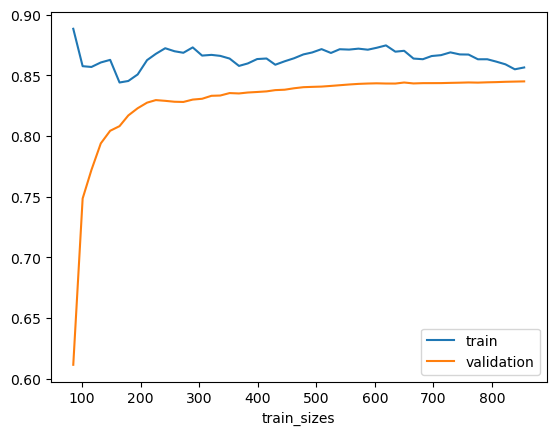

In [181]:
train_sizes, train_scores, test_scores = learning_curve(modelElastic,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50))                                         
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [182]:
y_pred = modelElastic.predict(X_train)

In [183]:
residual = (y_pred - y_train).abs().sort_values()

In [184]:
residual.describe()

count     1069.000000
mean      2600.266890
std       3811.681194
min          3.263582
25%       1134.098672
50%       1585.586425
75%       2011.900546
max      23916.004712
Name: charges, dtype: float64

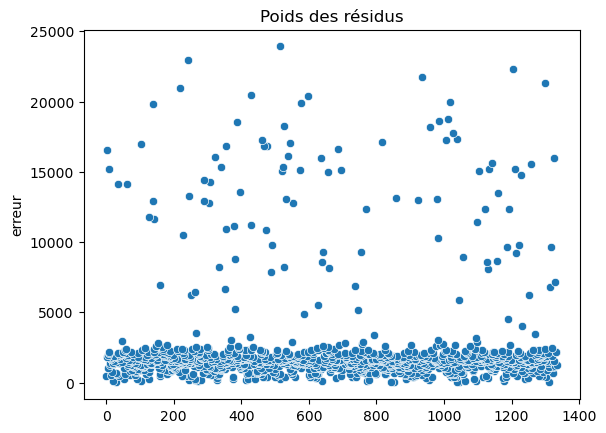

In [185]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [186]:
to_drop = residual[residual > 15000].index

In [187]:
X_train.loc[to_drop]

,age,sex,children,smoker,region,cat_bmi
1103,37,male,0,no,southwest,overweight
520,50,female,0,no,northeast,overweight
573,62,female,1,no,northeast,obesity
695,53,female,2,no,northeast,obesity
1210,39,male,2,no,southeast,obesity
1133,28,male,0,no,northwest,obesity
9,60,female,0,no,northwest,overweight
524,42,male,1,yes,southeast,overweight
340,24,female,0,no,southwest,overweight
1257,55,male,3,no,northwest,obesity


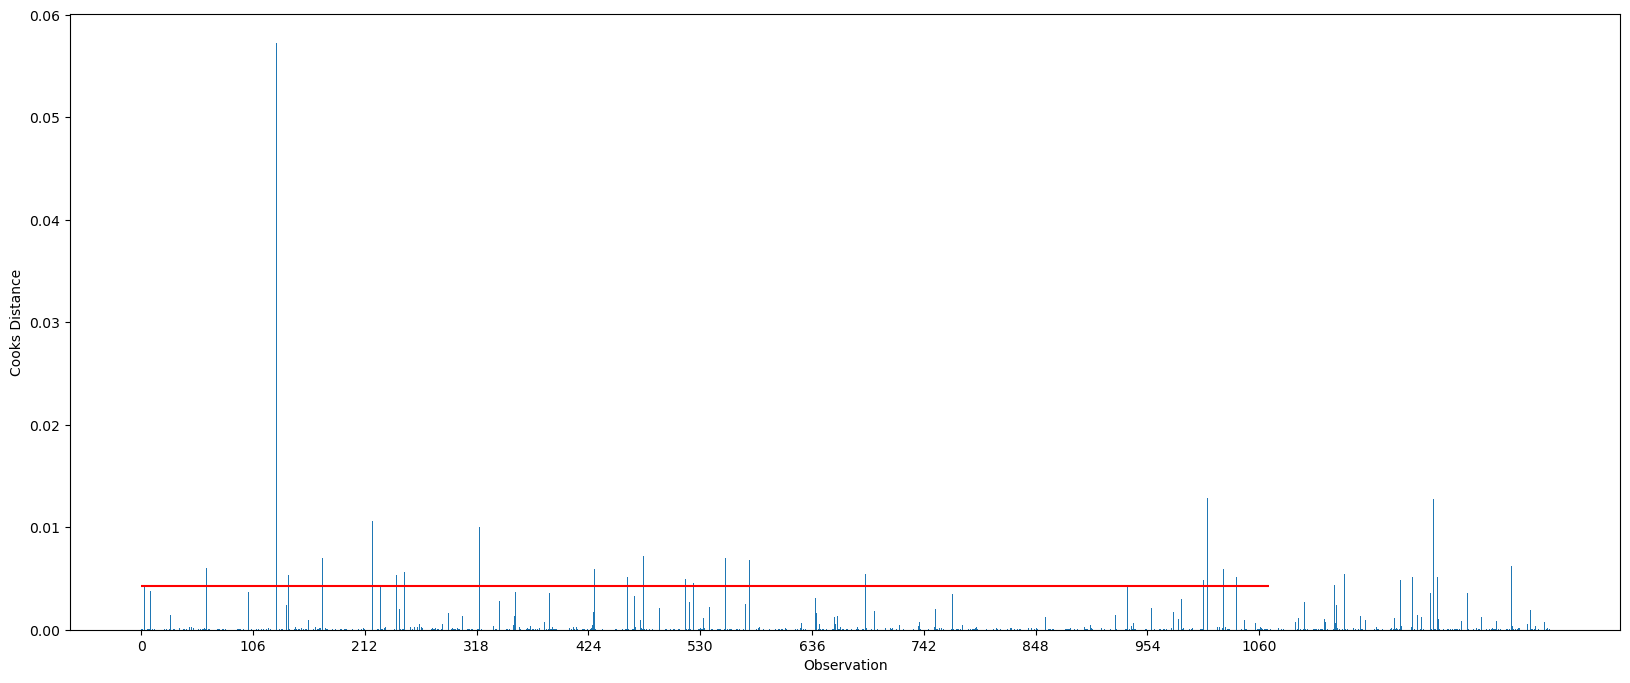

In [188]:


index_to_be_removed = get_index_to_remove_by_Cooks_Distance(X_train=X_train, y_train=y_train, preprocessor=make_pipeline(my_col_trans,PolynomialFeatures(degree=2)))

X_train = X_train.drop(index=index_to_be_removed.values)
y_train = y_train.drop(index=index_to_be_removed.values)




In [189]:
# parameters = {"elasticnet__alpha":np.linspace(0.1,100,100),"elasticnet__l1_ratio":np.arange(0.95,1,0.01)}

# randm_src = GridSearchCV(estimator=modelElastic, param_grid=parameters,scoring='r2',cv = 5)
# randm_src.fit(X_train, y_train)


# modelElastic.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_

modelElastic.set_params(**{'elasticnet__alpha': 13.218181818181817, 'elasticnet__l1_ratio': 1.0})


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('sclal', StandardScaler(),
                                                  ['age', 'children']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'smoker', 'region',
                                                   'cat_bmi'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('elasticnet',
                 ElasticNet(alpha=13.218181818181817, l1_ratio=1.0,
                            max_iter=100000, random_state=42))])

In [190]:
kfold =KFold(n_splits=5,shuffle=True,random_state=42)
scores = cross_val_score(modelElastic,X_train,y_train)
print(scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.92421236 0.8881607  0.92069902 0.9209749  0.86238879]
CV Accuracy: 0.90 (+/- 0.05)


In [191]:


modelElastic.fit(X_train,y_train)
modelElastic.score(X_train,y_train)



0.9107568638972514

In [192]:


modelElastic.score(X_test,y_test)



0.9220067198705247

In [193]:
y_pred = modelElastic.predict(X_train)

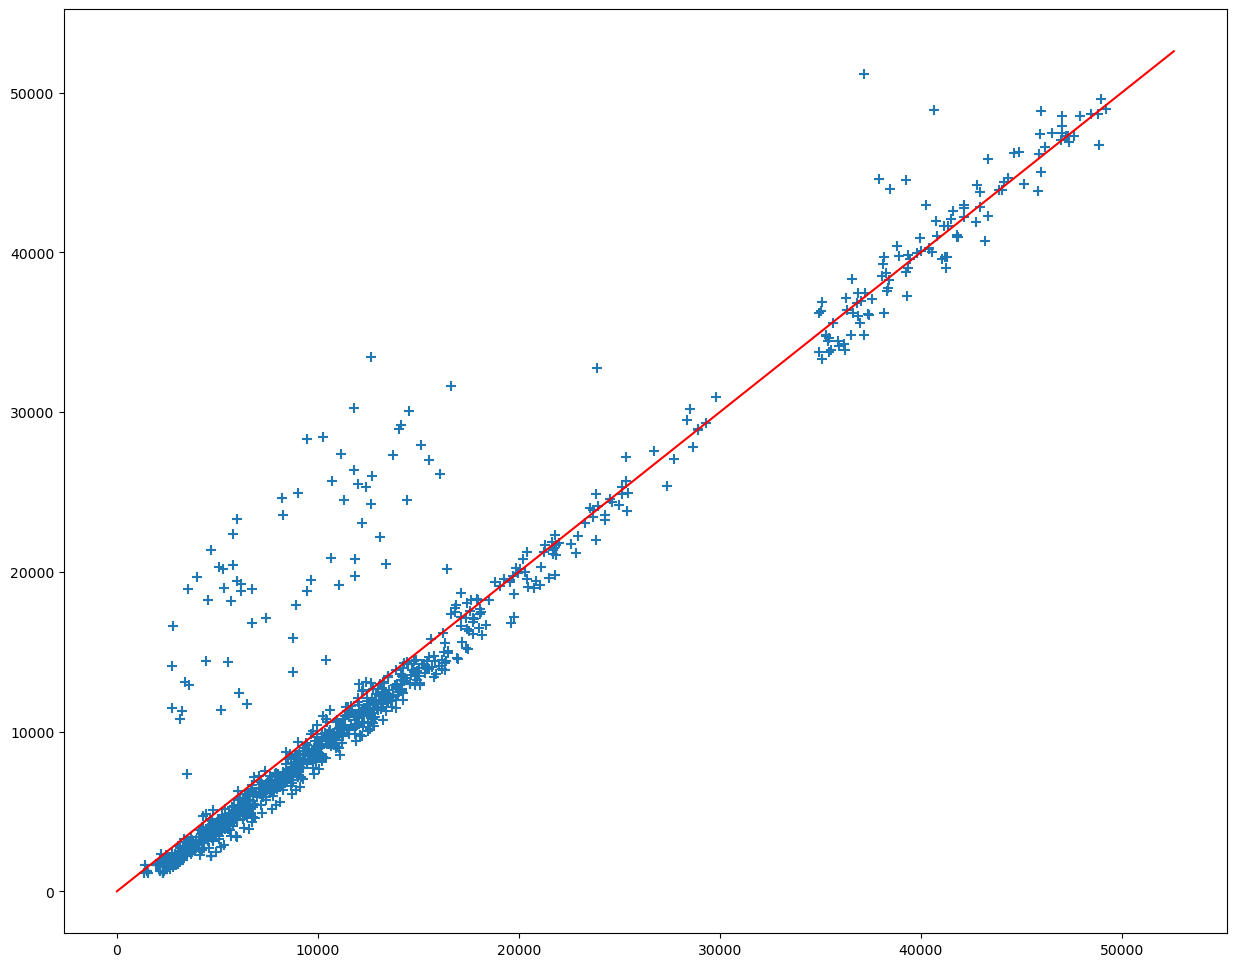

In [194]:
plt.subplots(figsize=(15, 12))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()

In [195]:
residual = (y_pred - y_train).abs().sort_values()

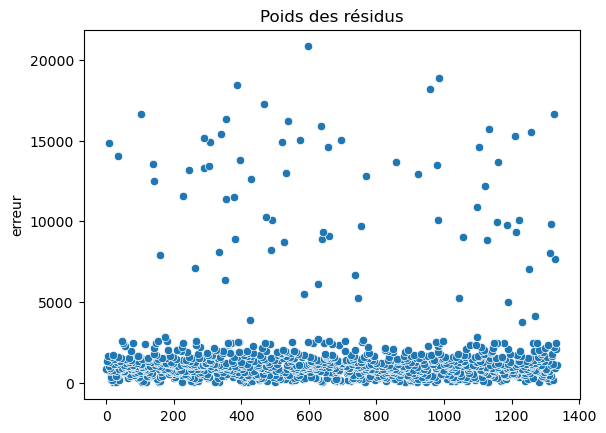

In [196]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [197]:
residual.describe()

count     1035.000000
mean      1796.370226
std       2979.498237
min          1.545420
25%        638.062350
50%       1046.736807
75%       1553.198586
max      20847.540290
Name: charges, dtype: float64

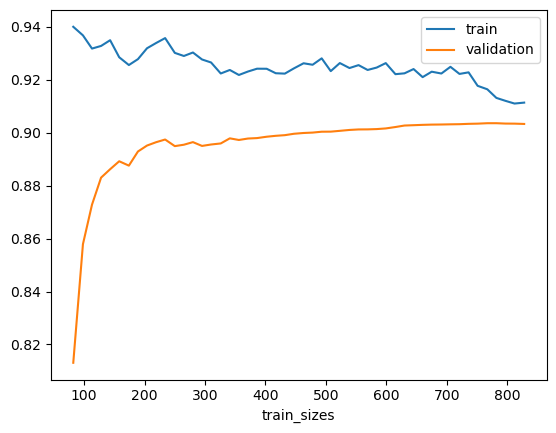

In [198]:
train_sizes, train_scores, test_scores = learning_curve(modelElastic,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50)) 
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [199]:
print(r2_score(modelElastic.predict(X_test),y_test))
print(mean_squared_error(modelElastic.predict(X_test),y_test,squared=False))

0.9124609235209424
3353.0824978088212


In [200]:
pickle_out = open("modelElastic.pkl", "wb") 
pickle.dump(modelElastic, pickle_out) 
pickle_out.close()